In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import GradientBoostingClassifier


2023-12-13 10:20:08.489905: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-13 10:20:08.532455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 10:20:08.532481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 10:20:08.533738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 10:20:08.540723: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 1
%aimport twitter_disaster_classification

In [3]:
training_data = pd.read_csv('train.csv', index_col='id')
print('The shape of the training data is ', training_data.shape)
training_data.head(3)

The shape of the training data is  (7613, 4)


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


### Gensim embeddings

In [4]:
pwd

'/home/utk.edu/nnaraya2/phase2/CS_522/Final_Project'

In [5]:

from gensim.models import KeyedVectors

# Load Google's pre-trained Word2Vec model.
model = KeyedVectors.load_word2vec_format('/home/utk.edu/nnaraya2/phase2/CS_522/Final_Project/GoogleNews-vectors-negative300.bin.gz', binary=True)


In [6]:

# Function to generate embeddings using Gensim's Word2Vec
def get_embeddings(text):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Apply the function to your text data
training_data['embeddings'] = training_data['text'].apply(get_embeddings)

# Convert embeddings to DataFrame
embedding_data = pd.DataFrame(training_data['embeddings'].tolist(), index=training_data.index)

# Add prefix to column names and save the changes
embedding_data = embedding_data.add_prefix('col_')

# Concatenate the original data with the embeddings
training_data = pd.concat([training_data, embedding_data], axis=1)

# Drop the 'text' and 'embeddings' columns
training_data.drop(['text', 'keyword','location','embeddings'], axis=1, inplace=True)

# Display the DataFrame
training_data


,target,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_290,col_291,col_292,col_293,col_294,col_295,col_296,col_297,col_298,col_299
id,,,,,,,,,,,,,,,,,,,,,
1,1,0.061501,0.079337,0.061364,0.094616,-0.118308,0.013148,0.029186,-0.010759,-0.016180,...,-0.051236,0.056910,-0.094394,-0.072132,-0.040405,-0.071983,-0.014859,-0.074222,0.033103,0.041304
4,1,0.036412,0.008789,0.121791,0.040667,0.082336,-0.038051,-0.081552,-0.040157,0.001877,...,0.025670,-0.044765,-0.099174,0.095167,-0.013781,-0.026542,-0.084752,-0.070783,0.053101,-0.023093
5,1,-0.025106,0.001458,0.113417,0.012178,-0.066956,-0.026988,0.007370,-0.011217,0.108331,...,-0.106649,-0.057666,-0.083171,0.000088,0.094007,0.051636,-0.074169,-0.012472,0.018378,-0.041538
6,1,0.085164,-0.031677,0.071065,0.099589,-0.001160,-0.059293,-0.087443,-0.016174,0.033056,...,0.048971,-0.037598,-0.081665,-0.039632,0.222697,0.065028,-0.107585,0.037313,0.057729,-0.035756
7,1,0.045420,0.043928,-0.014968,0.041950,-0.050180,-0.018193,0.006183,-0.107187,-0.018278,...,-0.060162,-0.035220,-0.084403,0.014921,-0.038364,0.015409,0.103953,-0.073268,0.023672,-0.004775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,1,0.049791,0.010386,0.022081,0.001031,0.006143,-0.152520,0.007399,-0.076440,0.192464,...,-0.167169,-0.038656,-0.125882,-0.053318,0.000224,-0.055881,-0.035482,-0.056953,0.017453,-0.080078
10870,1,0.060863,0.095651,0.021829,0.043631,-0.026031,-0.049726,-0.020351,-0.077790,0.051409,...,-0.021381,0.000791,-0.083514,0.055682,0.005598,-0.049866,-0.028840,0.035546,0.040928,-0.011139
10871,1,0.038757,-0.110596,0.051407,0.186035,-0.143799,0.012634,-0.149414,-0.202026,0.022675,...,0.150513,0.002716,-0.154297,0.104065,0.038818,-0.105469,-0.136719,0.046875,0.129532,0.106567


In [7]:
# Assuming 'training_data' is your DataFrame and 'target' is the column with labels
X = training_data.drop('target', axis=1)  # Features
y = training_data['target']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**SVM with embeddings**

In [8]:
# Creating and training the SVM model
svm_model = SVC(kernel='linear')  # You can try different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

# Making predictions
y_pred = svm_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
svm_metrics = twitter_disaster_classification.calculate_metrics(y_test, y_pred)
print(svm_metrics)


Accuracy: 0.7997373604727511
{'recall': 0.6687211093990755, 'precision': 0.8282442748091603, 'accuracy': 0.7997373604727511, 'tpr': 0.6687211093990755, 'tnr': 0.897025171624714}


**SVM with embeddings and sentiment**

In [9]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/utk.tennessee.edu/nnaraya2/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:


training_data = pd.read_csv('/home/utk.edu/nnaraya2/phase2/CS_522/Final_Project/train.csv', index_col='id')
print('The shape of the training data is ', training_data.shape)

# Function to generate embeddings using Gensim's Word2Vec
def get_embeddings(text):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Apply the function to your text data
training_data['embeddings'] = training_data['text'].apply(get_embeddings)

# Convert embeddings to DataFrame
embedding_data = pd.DataFrame(training_data['embeddings'].tolist(), index=training_data.index)

# Add prefix to column names and save the changes
embedding_data = embedding_data.add_prefix('col_')

# Concatenate the original data with the embeddings
training_data = pd.concat([training_data, embedding_data], axis=1)

training_data['sentiment'] =training_data['text'].map(lambda x:sia.polarity_scores(x)['neg'])


# Drop the 'text' and 'embeddings' columns
training_data.drop(['text', 'keyword','location','embeddings'], axis=1, inplace=True)

# Assuming 'training_data' is your DataFrame and 'target' is the column with labels
X = training_data.drop('target', axis=1)  # Features
y = training_data['target']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The shape of the training data is  (7613, 4)


In [13]:
# Assuming 'training_data' is your DataFrame and 'target' is the column with labels
X = training_data.drop('target', axis=1)  # Features
y = training_data['target']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Creating and training the SVM model
svm_model = SVC(kernel='linear')  # You can try different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

# Making predictions
y_pred = svm_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
svm_metrics = twitter_disaster_classification.calculate_metrics(y_test, y_pred)
print(svm_metrics)


Accuracy: 0.8010505581089954
{'recall': 0.6733436055469953, 'precision': 0.8276515151515151, 'accuracy': 0.8010505581089954, 'tpr': 0.6733436055469953, 'tnr': 0.8958810068649885}


**Bert Embeddings**

In [26]:
from transformers import BertTokenizer, BertModel
import torch

def get_bert_embeddings(text):
    # Load pre-trained model tokenizer (vocabulary)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Encode text and convert to tensor
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor([input_ids])

    # Load pre-trained model (weights)
    model = BertModel.from_pretrained('bert-base-uncased')

    # Check if GPU is available and move the model to GPU if it is
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    input_ids = input_ids.to(device)

    # Put the model in "evaluation" mode
    model.eval()

    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_states = outputs.last_hidden_state

    # Free up memory
    del model
    torch.cuda.empty_cache()

    return last_hidden_states.cpu().numpy()

# Example usage
text = "Example sentence for BERT embeddings"
embeddings = get_bert_embeddings


In [27]:
training_data = pd.read_csv('/home/utk.edu/nnaraya2/phase2/CS_522/Final_Project/train.csv', index_col='id')
print('The shape of the training data is ', training_data.shape)


# Apply the function to your text data
training_data['embeddings'] = training_data['text'].apply(get_bert_embeddings)

# Convert embeddings to DataFrame
embedding_data = pd.DataFrame(training_data['embeddings'].tolist(), index=training_data.index)

# Add prefix to column names and save the changes
embedding_data = embedding_data.add_prefix('col_')

# Concatenate the original data with the embeddings
training_data = pd.concat([training_data, embedding_data], axis=1)

# Drop the 'text' and 'embeddings' columns
training_data.drop(['text', 'keyword','location','embeddings'], axis=1, inplace=True)

# Assuming 'training_data' is your DataFrame and 'target' is the column with labels
X = training_data.drop('target', axis=1)  # Features
y = training_data['target']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The shape of the training data is  (7613, 4)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB (GPU 0; 44.43 GiB total capacity; 90.00 MiB already allocated; 4.81 MiB free; 90.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

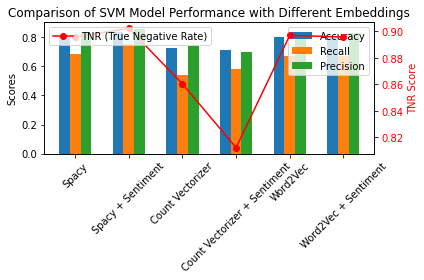

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ['Spacy', 'Spacy + Sentiment', 'Count Vectorizer', 'Count Vectorizer + Sentiment', 'Word2Vec', 'Word2Vec + Sentiment']
accuracy = [0.8049901510177282, 0.8353765323992994, 0.7242284963887065, 0.7156927117531189, 0.7997373604727511, 0.8010505581089954]
recall = [0.6825885978428351, 0.7514792899408284, 0.5408320493066255, 0.5855161787365177, 0.6687211093990755, 0.6733436055469953]
precision = [0.8295880149812734, 0.8600451467268623, 0.7420718816067653, 0.6985294117647058, 0.8282442748091603, 0.8276515151515151]
tnr = [0.8958810068649885, 0.9023622047244094, 0.8604118993135011, 0.8123569794050344, 0.897025171624714, 0.8958810068649885]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, precision, width, label='Precision')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of SVM Model Performance with Different Embeddings')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

# Adding TNR as a line plot for clarity
ax2 = ax.twinx()
ax2.plot(models, tnr, color='red', marker='o', label='TNR (True Negative Rate)')
ax2.set_ylabel('TNR Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper left')

fig.tight_layout()
plt.show()



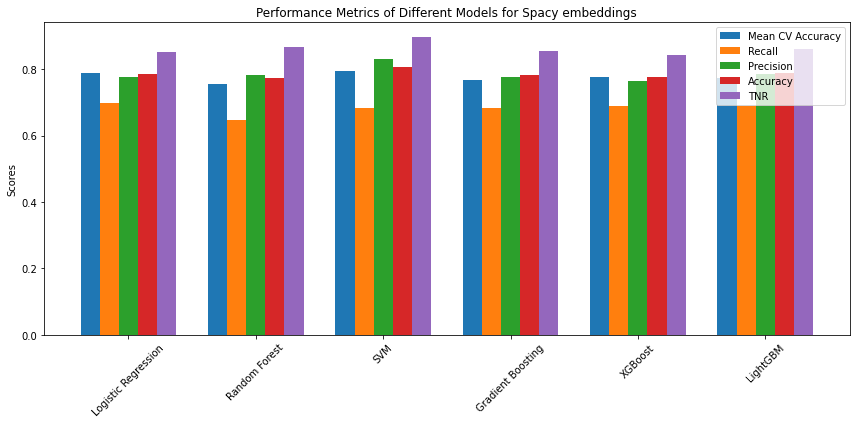

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting', 'XGBoost', 'LightGBM']
mean_cv_accuracy = [0.7890, 0.7542, 0.7957, 0.7681, 0.7749, 0.7744]
recall = [0.6995, 0.6471, 0.6826, 0.6826, 0.6903, 0.6903]
precision = [0.7761, 0.7836, 0.8296, 0.7772, 0.7645, 0.7859]
accuracy = [0.7859, 0.7735, 0.8050, 0.7814, 0.7774, 0.7879]
tnr = [0.8501, 0.8673, 0.8959, 0.8547, 0.8421, 0.8604]

x = np.arange(len(models))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 2*width, mean_cv_accuracy, width, label='Mean CV Accuracy')
rects2 = ax.bar(x - width, recall, width, label='Recall')
rects3 = ax.bar(x, precision, width, label='Precision')
rects4 = ax.bar(x + width, accuracy, width, label='Accuracy')
rects5 = ax.bar(x + 2*width, tnr, width, label='TNR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Different Models for Spacy embeddings')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()


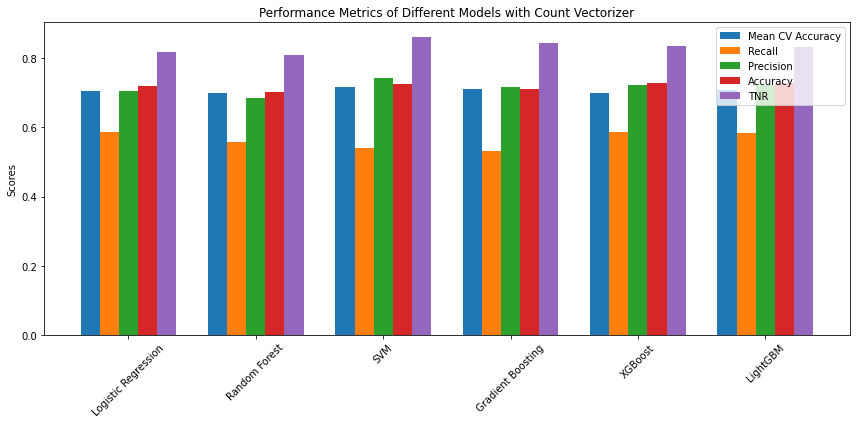

In [18]:
# Data for the Count Vectorizer Model Performance
models_cv = ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting', 'XGBoost', 'LightGBM']
mean_cv_accuracy_cv = [0.7061, 0.6997, 0.7158, 0.7112, 0.6993, 0.7082]
recall_cv = [0.5855, 0.5578, 0.5408, 0.5331, 0.5855, 0.5840]
precision_cv = [0.7063, 0.6843, 0.7421, 0.7164, 0.7238, 0.7219]
accuracy_cv = [0.7196, 0.7019, 0.7242, 0.7110, 0.7282, 0.7269]
tnr_cv = [0.8192, 0.8089, 0.8604, 0.8432, 0.8341, 0.8330]

x_cv = np.arange(len(models_cv))  # the label locations
width_cv = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x_cv - 2*width_cv, mean_cv_accuracy_cv, width_cv, label='Mean CV Accuracy')
rects2 = ax.bar(x_cv - width_cv, recall_cv, width_cv, label='Recall')
rects3 = ax.bar(x_cv, precision_cv, width_cv, label='Precision')
rects4 = ax.bar(x_cv + width_cv, accuracy_cv, width_cv, label='Accuracy')
rects5 = ax.bar(x_cv + 2*width_cv, tnr_cv, width_cv, label='TNR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Different Models with Count Vectorizer')
ax.set_xticks(x_cv)
ax.set_xticklabels(models_cv, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()


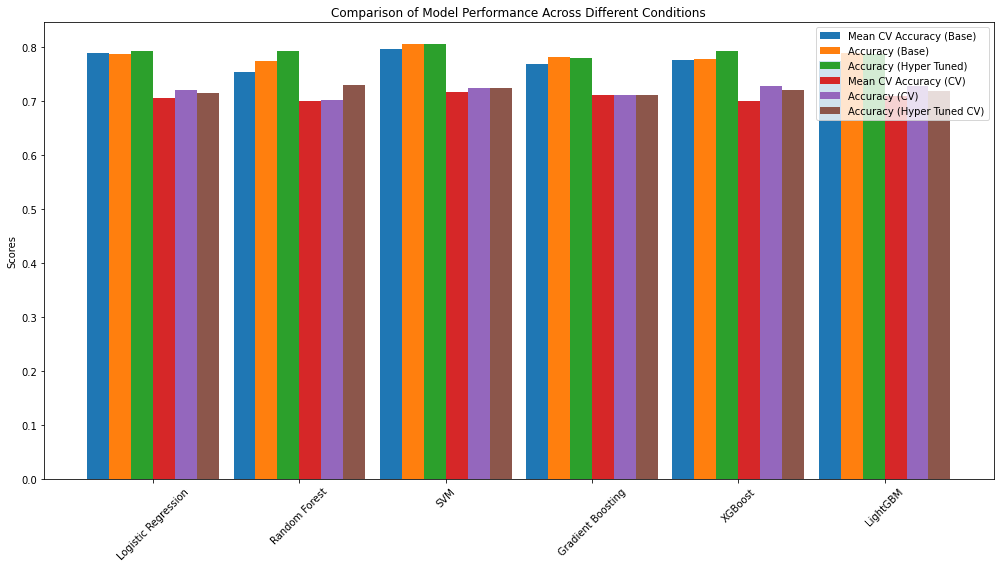

In [19]:
# Data for all tables
models = ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting', 'XGBoost', 'LightGBM']

# Base Model Performance
mean_cv_accuracy_base = [0.7890, 0.7542, 0.7957, 0.7681, 0.7749, 0.7744]
accuracy_base = [0.7859, 0.7735, 0.8050, 0.7814, 0.7774, 0.7879]

# Hyperparameter Tuned Model Performance
accuracy_hyper = [0.7932, 0.7932, 0.8050, 0.7800, 0.7932, 0.7866]

# Count Vectorizer Model Performance
mean_cv_accuracy_cv = [0.7061, 0.6997, 0.7158, 0.7112, 0.6993, 0.7082]
accuracy_cv = [0.7196, 0.7019, 0.7242, 0.7110, 0.7282, 0.7269]

# Hyperparameter Tuned Model Performance using Count Vectorizer
accuracy_hyper_cv = [0.7150, 0.7295, 0.7242, 0.7104, 0.7196, 0.7189]

x = np.arange(len(models))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))

# Base Model Performance
rects1 = ax.bar(x - 2.5*width, mean_cv_accuracy_base, width, label='Mean CV Accuracy (Base)')
rects2 = ax.bar(x - 1.5*width, accuracy_base, width, label='Accuracy (Base)')

# Hyperparameter Tuned Model Performance
rects3 = ax.bar(x - 0.5*width, accuracy_hyper, width, label='Accuracy (Hyper Tuned)')

# Count Vectorizer Model Performance
rects4 = ax.bar(x + 0.5*width, mean_cv_accuracy_cv, width, label='Mean CV Accuracy (CV)')
rects5 = ax.bar(x + 1.5*width, accuracy_cv, width, label='Accuracy (CV)')

# Hyperparameter Tuned Model Performance using Count Vectorizer
rects6 = ax.bar(x + 2.5*width, accuracy_hyper_cv, width, label='Accuracy (Hyper Tuned CV)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Across Different Conditions')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()


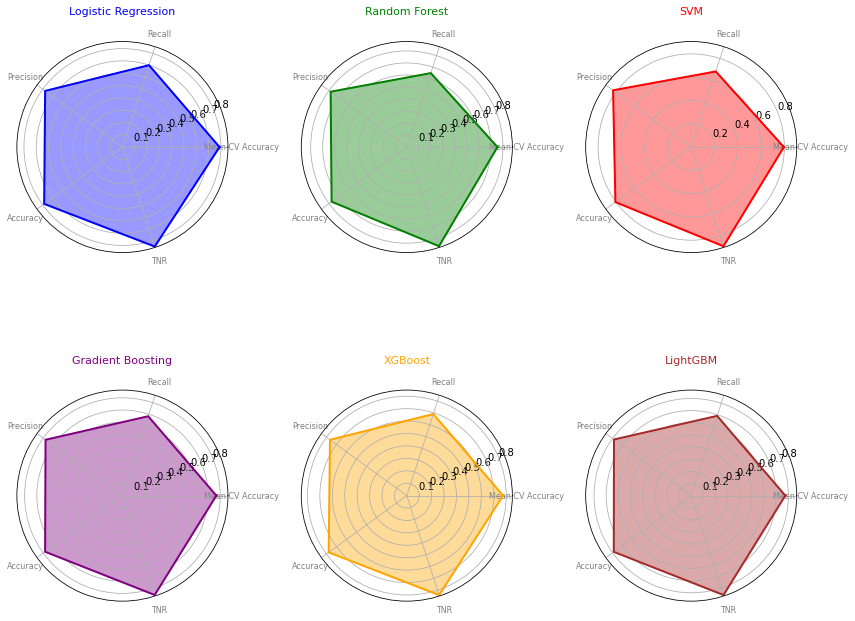

In [21]:
# Radar Chart to show the performance of each model across different metrics

# Import necessary libraries
import matplotlib.pyplot as plt
from math import pi

# Function to create radar chart for each model
def create_radar_chart(model_name, data, color):
    categories = list(data.keys())
    N = len(categories)

    # Inside the create_radar_chart function
    values = list(data.values())  # Convert dict_values to list
    values += values[:1]  # repeat the first value to close the circular graph


    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(2, 3, models.index(model_name) + 1, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    plt.title(model_name, size=11, color=color, y=1.1)

# Data for each model
data_logistic_regression = {
    'Mean CV Accuracy': 0.7890,
    'Recall': 0.6995,
    'Precision': 0.7761,
    'Accuracy': 0.7859,
    'TNR': 0.8501
}

data_random_forest = {
    'Mean CV Accuracy': 0.7542,
    'Recall': 0.6471,
    'Precision': 0.7836,
    'Accuracy': 0.7735,
    'TNR': 0.8673
}

data_svm = {
    'Mean CV Accuracy': 0.7957,
    'Recall': 0.6826,
    'Precision': 0.8296,
    'Accuracy': 0.8050,
    'TNR': 0.8959
}

data_gradient_boosting = {
    'Mean CV Accuracy': 0.7681,
    'Recall': 0.6826,
    'Precision': 0.7772,
    'Accuracy': 0.7814,
    'TNR': 0.8547
}

data_xgboost = {
    'Mean CV Accuracy': 0.7749,
    'Recall': 0.6903,
    'Precision': 0.7645,
    'Accuracy': 0.7774,
    'TNR': 0.8421
}

data_lightgbm = {
    'Mean CV Accuracy': 0.7744,
    'Recall': 0.6903,
    'Precision': 0.7859,
    'Accuracy': 0.7879,
    'TNR': 0.8604
}

# Create radar chart for each model
plt.figure(figsize=(12, 10))
create_radar_chart('Logistic Regression', data_logistic_regression, 'blue')
create_radar_chart('Random Forest', data_random_forest, 'green')
create_radar_chart('SVM', data_svm, 'red')
create_radar_chart('Gradient Boosting', data_gradient_boosting, 'purple')
create_radar_chart('XGBoost', data_xgboost, 'orange')
create_radar_chart('LightGBM', data_lightgbm, 'brown')

# Show plot
plt.tight_layout()
plt.show()
